# Random Forests and Gradient Boosted Regression Trees

We will look here into the practicalities of fitting random forests and GBRT. These involve out-of-bound estmates and cross-validation, and how you might want to deal with hyperparameters in these models. Along the way we will play a little bit with different loss functions, so that you start thinking about what goes in general into cooking up a machine learning model.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Dataset

First, the data. This one is built into sklearn, its a dataset about california housing prices. Its quite skewed as we shall see.

In [2]:
elect_df = pd.read_csv("data/county_level_election.csv")
elect_df.head()

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# split 80/20 train-test
X = elect_df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
response = elect_df['votergap']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,response,test_size=0.2)


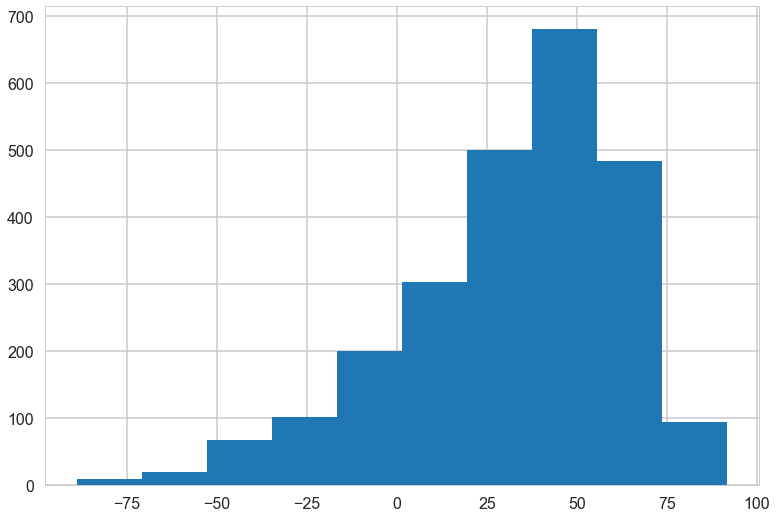

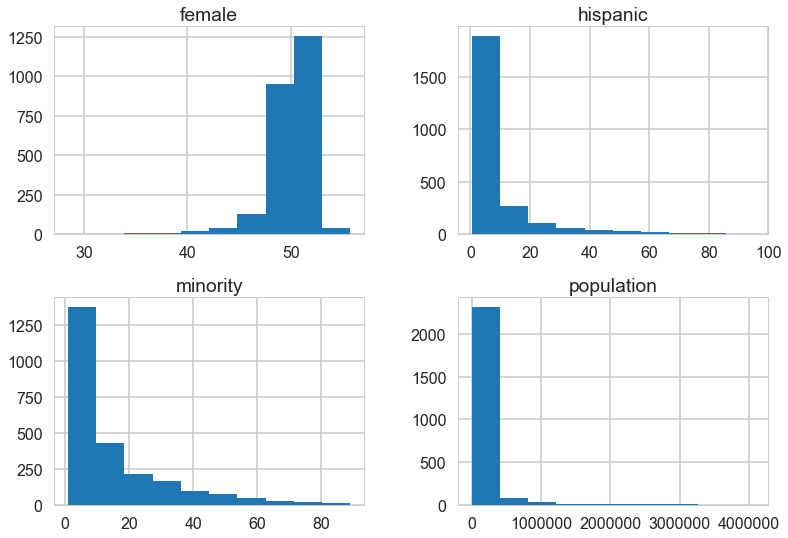

In [5]:
plt.hist(ytrain)
Xtrain.hist(column=['minority', 'population','hispanic','female']);

How would you describe these variables?

In [6]:
print(elect_df.shape)
print(Xtrain.shape)
print(Xtest.shape)

(3066, 18)
(2452, 12)
(614, 12)


## General Trees

We could use a simple Decision Tree regressor to fit such a model. Thats not the aim of this lab, so we'll run one such model without any cross-validation or regularization.

This is what you ought to keep in mind about decision trees.

from the docs:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias.

In [7]:
from sklearn.tree import DecisionTreeRegressor
#x = np.arange(0, 2*np.pi, 0.1)
#y = np.sin(x) + 0.1*np.random.normal(size=x.shape[0])
x = Xtrain['minority'].values
o = np.argsort(x)
x = x[o]
y = ytrain.values
y = y[o]


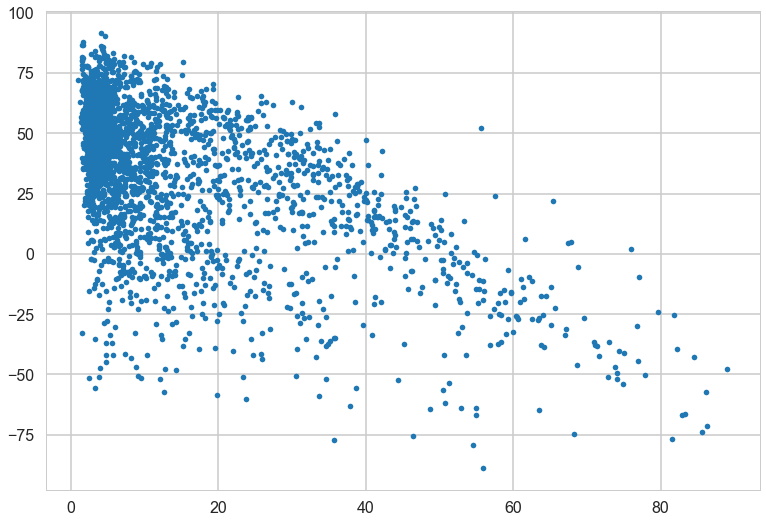

In [8]:
plt.plot(x,y, '.');

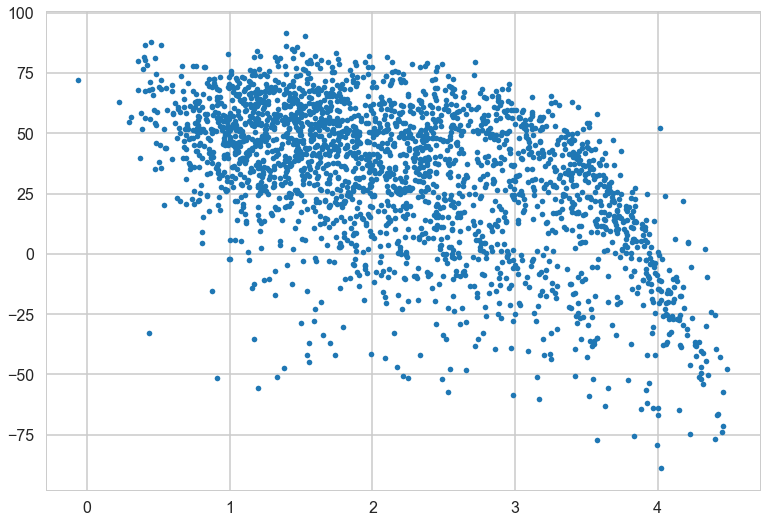

In [9]:
plt.plot(np.log(x),y, '.');

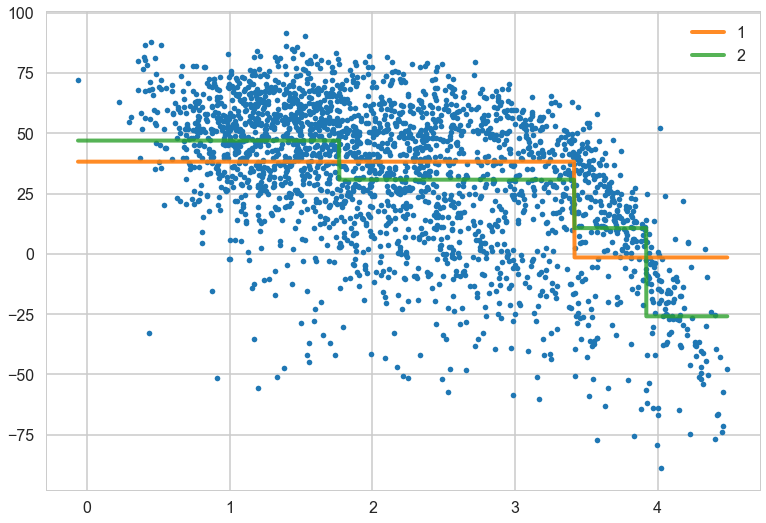

In [10]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [1,2]:
    dtree = DecisionTreeRegressor(max_depth=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=1-i/10, lw=4)
plt.legend();

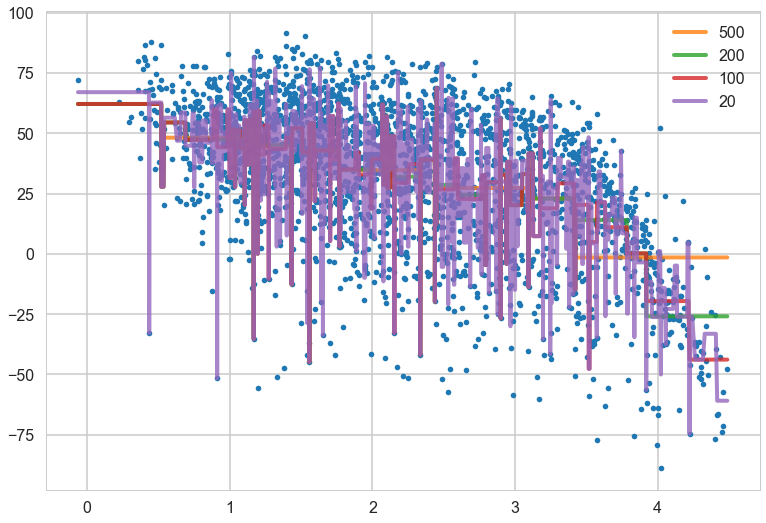

In [11]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [500,200,100,20]:
    dtree = DecisionTreeRegressor(min_samples_split=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=0.8, lw=4)
plt.legend();

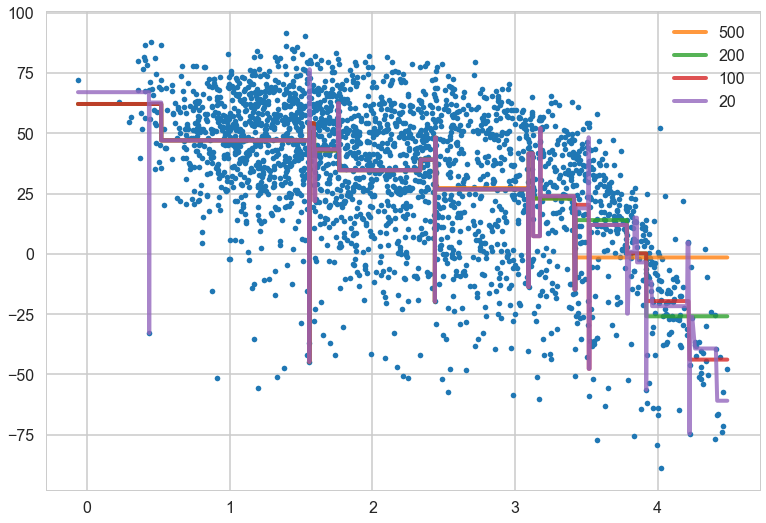

In [12]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [500,200,100,20]:
    dtree = DecisionTreeRegressor(max_depth=6, min_samples_split=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=0.8, lw=4)
plt.legend();

Ok with this discussion in mind, lets approach Random Forests.

## Random Forests

Whats the basic idea?

- Decision trees overfit
- So lets introduce randomization.
- Randomization 1: Use bootstrap resampling to create different training datasets. This way each training will give us a different tree and the robust aspects of the regression will remain.
- Added advantage is that the left off points can be used to "validate"
- Just like in polynomials we can choose a large `max_depth` and we are ok as we expect the robust signal to remain

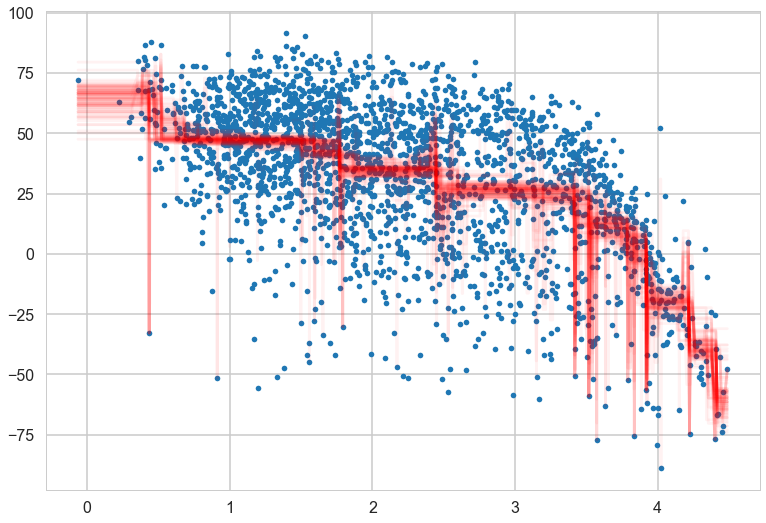

In [13]:
plt.plot(np.log(x),y,'.')
for i in range(100):
    dtree = DecisionTreeRegressor(max_depth=4)
    isamp = np.random.choice(range(x.shape[0]), replace=True, size=x.shape[0])
    xx = np.log(x)[isamp].reshape(-1,1)
    dtree.fit(xx, y[isamp])
    plt.plot(np.log(x), dtree.predict(np.log(x).reshape(-1,1)), 'r', alpha=0.05)

In [14]:
#let's also include logminority as a predictor
xtemp = np.log(Xtrain['minority'].values)
Xtrain = Xtrain.assign(logminority = xtemp)
Xtest = Xtest.assign(logminority = np.log(Xtest['minority'].values))
Xtrain.head()


,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,logminority
2269,38813,1.140,3.252,50.735,7.0,31086,25.4,14.5,34.9,36.3,41.0,263.5,1.179270
381,8706,6.030,5.439,48.071,3.7,69115,4.0,40.8,16.5,18.1,23.0,162.3,1.693595
1449,44407,40.859,13.899,48.044,4.9,42620,17.9,20.4,25.8,30.5,3.7,225.8,2.631817
1815,7202,0.697,3.156,45.927,5.7,41838,18.1,12.7,34.2,35.7,25.7,242.0,1.149305
441,20290,0.981,83.359,52.426,12.1,22640,29.6,12.0,37.5,46.1,282.0,166.4,4.423157


But this is not enough randomization, because even after bootstrapping, you are mainly training on the same data points, those that appear more often, and will retain some overfitting.

We can't do anything in 1-D but in more than 1-D we can choose what predictors to split on randomly, and how many to do this on. This gets us a random forest.

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
# code from 
# Adventures in scikit-learn's Random Forest by Gregory Saunders
from itertools import product
from collections import OrderedDict
param_dict = OrderedDict(
    n_estimators = [400, 600, 800],
    max_features = [0.2, 0.4, 0.6, 0.8]
)

param_dict.values()

odict_values([[400, 600, 800], [0.2, 0.4, 0.6, 0.8]])

Here we create a Param Grid. We are preparing to use the bootstrap points not used to validate.

```
max_features : int, float, string or None, optional (default=”auto”)
The number of features to consider when looking for the best split.
```

- `max_features`: Default splits on all the features and is probably prone to overfitting. You'll want to validate on this. 
- You can "validate" on the trees `n_estimators` as well but many a times you will just look for the plateau in the trees as seen below.
- From decision trees you get the `max_depth`, `min_samples_split`, and `min_samples_leaf` as well but you might as well leave those at defaults to get a maximally expanded tree.

### Using the OOB score.

We have been putting "validate" in quotes. This is because the bootstrap gives us left-over points! So we'll now engage in our very own version of a grid-search, done over the out-of-bag scores that `sklearn` gives us for free

In [17]:
from itertools import product

In [18]:
#make sure ytrain is the correct data tyoe
yytrain = np.ravel(ytrain)

#Let's Cross-val. on the two 'hyperparameters' we based our grid on earlier
results = {}
estimators= {}
for ntrees, maxf in product(*param_dict.values()):
    params = (ntrees, maxf)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=ntrees, max_features=maxf, max_depth=50, n_jobs=-1)
    est.fit(Xtrain, yytrain)
    results[params] = est.oob_score_
    estimators[params] = est
outparams = max(results, key = results.get)
outparams

(600, 0.6)

In [19]:
print(yytrain.shape,ytrain.shape,x.shape)

(2452,) (2452,) (2452,)


In [20]:
rf1 = estimators[outparams]

In [21]:
results

{(400, 0.2): 0.75249655245115088,
 (400, 0.4): 0.76718735757321099,
 (400, 0.6): 0.76826277532591192,
 (400, 0.8): 0.7683774023591422,
 (600, 0.2): 0.75309753815772251,
 (600, 0.4): 0.76989152855900178,
 (600, 0.6): 0.77028779606704978,
 (600, 0.8): 0.77022867429540498,
 (800, 0.2): 0.75407237618141021,
 (800, 0.4): 0.76921727336948198,
 (800, 0.6): 0.76973937765431777,
 (800, 0.8): 0.77003719793379988}

In [22]:
rf1.score(Xtest, ytest)

0.77706450174265362

Since our response isn't very symmetric, we may want to suppress outliers by using the `mean_absolute_error` instead. 

In [23]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, rf1.predict(Xtest))

11.752390716612377

`sklearn` supports this (`criterion='mae'`) since v0.18, but does not have arbitrary loss functions for Random Forests.

YOUR TURN NOW
>Lets try this with MAE

In [24]:
# your code here

Finally you can get feature importances. Whenever a feature is used in a tree in the forest, the algorithm will log the decrease in the splitting criterion such as gini. This is accumulated over all trees and reported in `est.feature_importances_`

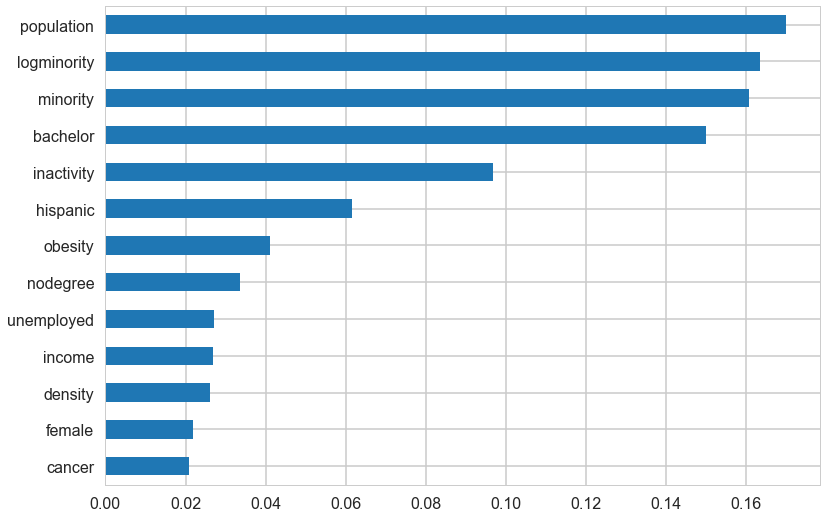

In [25]:
pd.Series(rf1.feature_importances_,index=list(Xtrain)).sort_values().plot(kind="barh")

You can do cross-validation if you want, and a cv of 3 will roughly be comparable (same approximate train-vs.-validation set sizes). But this will take much more time as you are doing the fit 3 times plus the bootstraps. So atleast three times as long!

In [26]:
param_dict2 = OrderedDict(
    n_estimators = [600],
    max_features = [0.2, 0.4, 0.6]
)

In [27]:
from sklearn.model_selection import GridSearchCV
est2 = RandomForestRegressor(oob_score=False)
gs = GridSearchCV(est2, param_grid = param_dict2, cv=3, n_jobs=-1)
gs.fit(Xtrain, ytrain)


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=OrderedDict([('n_estimators', [600]), ('max_features', [0.2, 0.4, 0.6])]),
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [28]:
rf2 = gs.best_estimator_
rf2

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [29]:
gs.best_score_

0.75686632652360286

How would you support scoring using mean absolute error if you use cross-validation?

### Seeing error as a function of the number of trees

We can instead, of different `max_features` see how performance varies across the number of trees one uses:

In [30]:
# from http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

feats = param_dict['max_features']
# 
error_rate = OrderedDict((label, []) for label in feats)

# Range of `n_estimators` values to explore.
min_estimators = 200
step_estimators = 200
num_steps = 3
max_estimators = min_estimators + step_estimators*num_steps
for label in feats:
    for i in range(min_estimators, max_estimators+1, step_estimators):
        clf = RandomForestRegressor(oob_score=True, max_features=label)
        clf.set_params(n_estimators=i)
        clf.fit(Xtrain, ytrain)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

In [31]:
print(feats)

[0.2, 0.4, 0.6, 0.8]


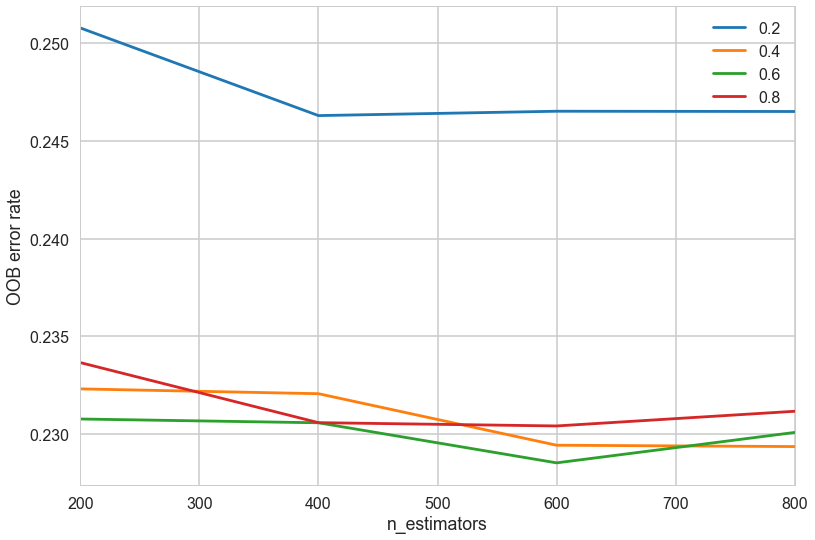

In [32]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

## Gradient Boosted Regression Trees

Adaboost Classification, which you will be doing in your homework, is a special case of a gradient-boosted algorithm. Gradient Bossting is very state of the art, and has major connections to logistic regression, gradient descent in a functional space, and search in information space. See Shapire and Freund's MIT Press book for details.

But briefly, let us cover the idea here. The idea is that we will use a bunch of weak 'learners' (aka, models) and fit sequentially. The first one fits the signal, the second one the first model's residual, the third the second model's residual, and so on. At each stage we upweight the places that our previous model did badly on. First let us illustrate.

In [33]:
from sklearn.ensemble import AdaBoostRegressor
estab = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1),n_estimators=500, learning_rate=1.0)
estab.fit(xx, y)
staged_predict_generator = estab.staged_predict(xx)

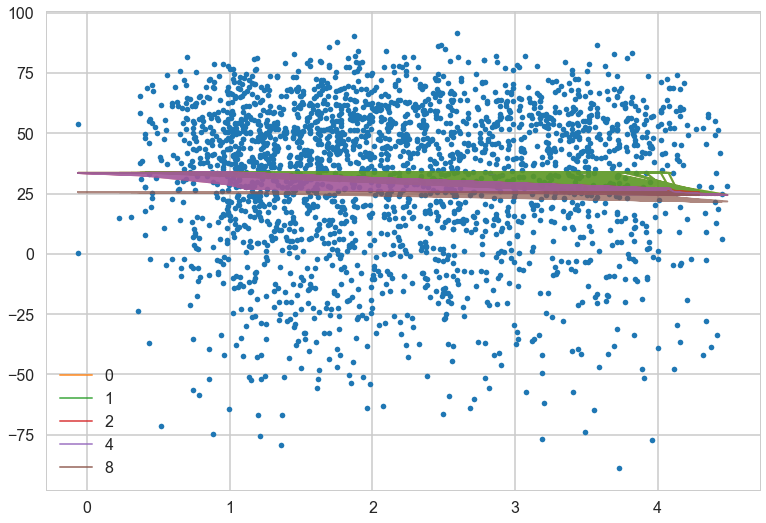

In [34]:
# code from http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb
import time
from IPython import display
plt.plot(xx, y, '.');
i = 0 
counter = 0
for stagepred in staged_predict_generator:
    if i in [0, 1, 2, 4, 8, 20, 50, 100, 200, 400, 500]:
        plt.plot(xx, stagepred, alpha=0.7, label=str(i), lw=2)
        plt.legend();
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(2 - counter*0.1)
        counter = counter + 1
    i = i + 1

Ok, so this demonstration helps us understand some things about GBRT.

- `n_estimators` is the number of trees, and thus the stage in the fitting. It also controls the complexity for us. The more trees we have the more we fit to the tiny details.
- `staged_predict` gives us the prediction at each step
- once again `max_depth` from the underlying decision tree tells us the depth of the tree. But here it tells us the amount of features interactions we have, not just the scale of our fit. But clearly it increases the variance again.

Ideas from decision trees remain. For example, increase `min_samples_leaf` to increase the bias.

YOUR TURN NOW

>Demonstrate what happens when you increase `max_depth` to 5

In [35]:
# your code here

YOUR TURN NOW

> What happens if you put `max_depth` back to 1 and decrease the learning rate to 0.1?

In [36]:
# your code here

### Whats the relationship between residuals and the gradient?

Pavlos showed in class that for the squared loss, taking the gradient in the "data point functional space", ie a N-d space for N data points with each variable being $f(x_i)$ just gives us the residuals. It turns out that the gradient descent is a more general idea, and one can use this for different losses. And the upweighting of poorly fit points in AdaBoost is simply a weighing by gradient. If the gradient (or residual) is high it means you are far away from optimum in this functional space, and if you are at 0, you have a flat gradient!

The ideas from the general theory of gradient descent tell us this: we can slow the learning by shrinking the predictions of each tree by some small number, which is called the learning_rate (learning_rate). This "shrinkage" helps us not overshoot, but for a finite number of iterations also simultaneously ensures we dont overfit by being in the neighboorhood of the minimum rather than just at it! But we might need to increase the iterations some to get into the minimum area.

### Ok, so how to do the fit?

In [59]:
max_est = 300
ab = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),n_estimators=max_est)
ab.fit(Xtrain, ytrain)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=None)

A deviance plot can be used to compare train and test errors against the number of iterations.

- Training error (deviance, related to the KL-divergence) is stored in `est.train_score_`
- Test error is computed using `est.staged_predict` 

In [60]:
from sklearn.metrics import r2_score

def deviance_plot(est, X_test, y_test, Xtrain, ytrain, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """MSE loss plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = 1-r2_score(y_test, pred)

    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    #ax.plot(np.arange(n_estimators) + 1, 1-est.score(Xtrain, ytrain), color=train_color, 
    #         label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

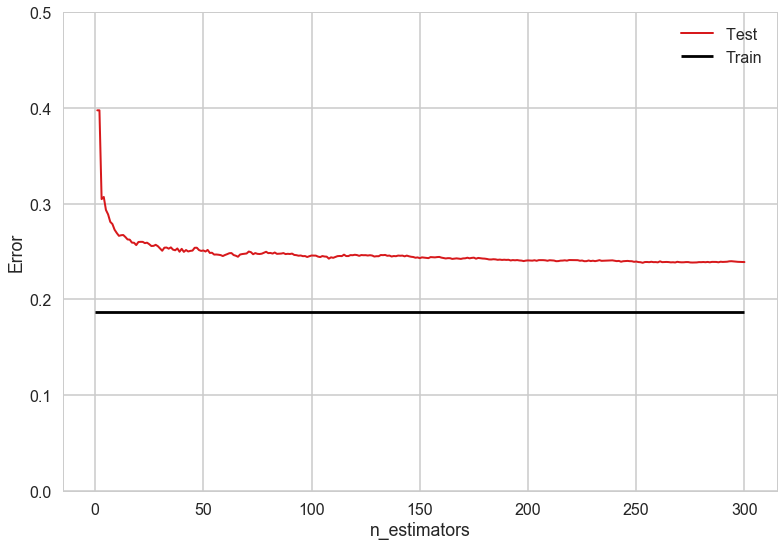

In [64]:
trainR2 = ab.score(Xtrain, ytrain)
deviance_plot(ab, Xtest, ytest, Xtrain, ytrain, ylim=(0,0.5))
plt.hlines(y=1-trainR2,xmin=0,xmax=max_est,label="Train")

plt.legend();

Notice the wide gap. This is an indication of overfitting!

Unlike random forests, where we are using the randomness to our benefits, the AdaBoost requires careful cross-validation

Peter Prettenhofer, who wrote sklearns' GBRT implementation writes in his pydata14 talk (worth watching!)

>Hyperparameter tuning
I usually follow this recipe to tune the hyperparameters:

>- Pick n_estimators as large as (computationally) possible (e.g. 1000+)
- Tune max_depth, learning_rate, min_samples_leaf, and max_features via grid search
- A lower learning_rate requires a higher number of n_estimators. Thus increase n_estimators even more and tune learning_rate again holding the other parameters fixed

This last point is a tradeof between number of iterations or runtime against accuracy. And keep in mind that it might lead to overfitting.

Note that poor learners do rather well. So you might want to not cross-validate `max_depth`. And `min_samples_per_leaf` is not independent either, so if you do use cross-val, you might just use one of those.

In [49]:
ab.score(Xtrain, ytrain)

0.81329020070922198